# HW9. Регрессионный анализ.
#### Ильичёв А.С., 693

In [115]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts
import pandas as pd
from statsmodels.stats.multitest import multipletests
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline


%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 5) 

## Задача 2.

In [2]:
df = pd.read_csv('Prostate_train_2019.csv')
df.head()

,id,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
0,1,-0.579818,2.769459,50.0,-1.386294,0.0,-1.386294,6.0,0.0,-0.430783
1,2,-0.994252,3.319626,58.0,-1.386294,0.0,-1.386294,6.0,0.0,-0.162519
2,3,-0.510826,2.691243,74.0,-1.386294,0.0,-1.386294,7.0,20.0,-0.162519
3,4,-1.203973,3.282789,58.0,-1.386294,0.0,-1.386294,6.0,0.0,-0.162519
4,5,0.751416,3.432373,62.0,-1.386294,0.0,-1.386294,6.0,0.0,0.371564


In [3]:
len(df)

97

In [4]:
train_df = df[df['lpsa'].notnull()]
len(train_df)

68

In [5]:
test_df = df[~df['lpsa'].notnull()]
len(test_df)

29

In [6]:
train_df.head(5)

,id,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
0,1,-0.579818,2.769459,50.0,-1.386294,0.0,-1.386294,6.0,0.0,-0.430783
1,2,-0.994252,3.319626,58.0,-1.386294,0.0,-1.386294,6.0,0.0,-0.162519
2,3,-0.510826,2.691243,74.0,-1.386294,0.0,-1.386294,7.0,20.0,-0.162519
3,4,-1.203973,3.282789,58.0,-1.386294,0.0,-1.386294,6.0,0.0,-0.162519
4,5,0.751416,3.432373,62.0,-1.386294,0.0,-1.386294,6.0,0.0,0.371564


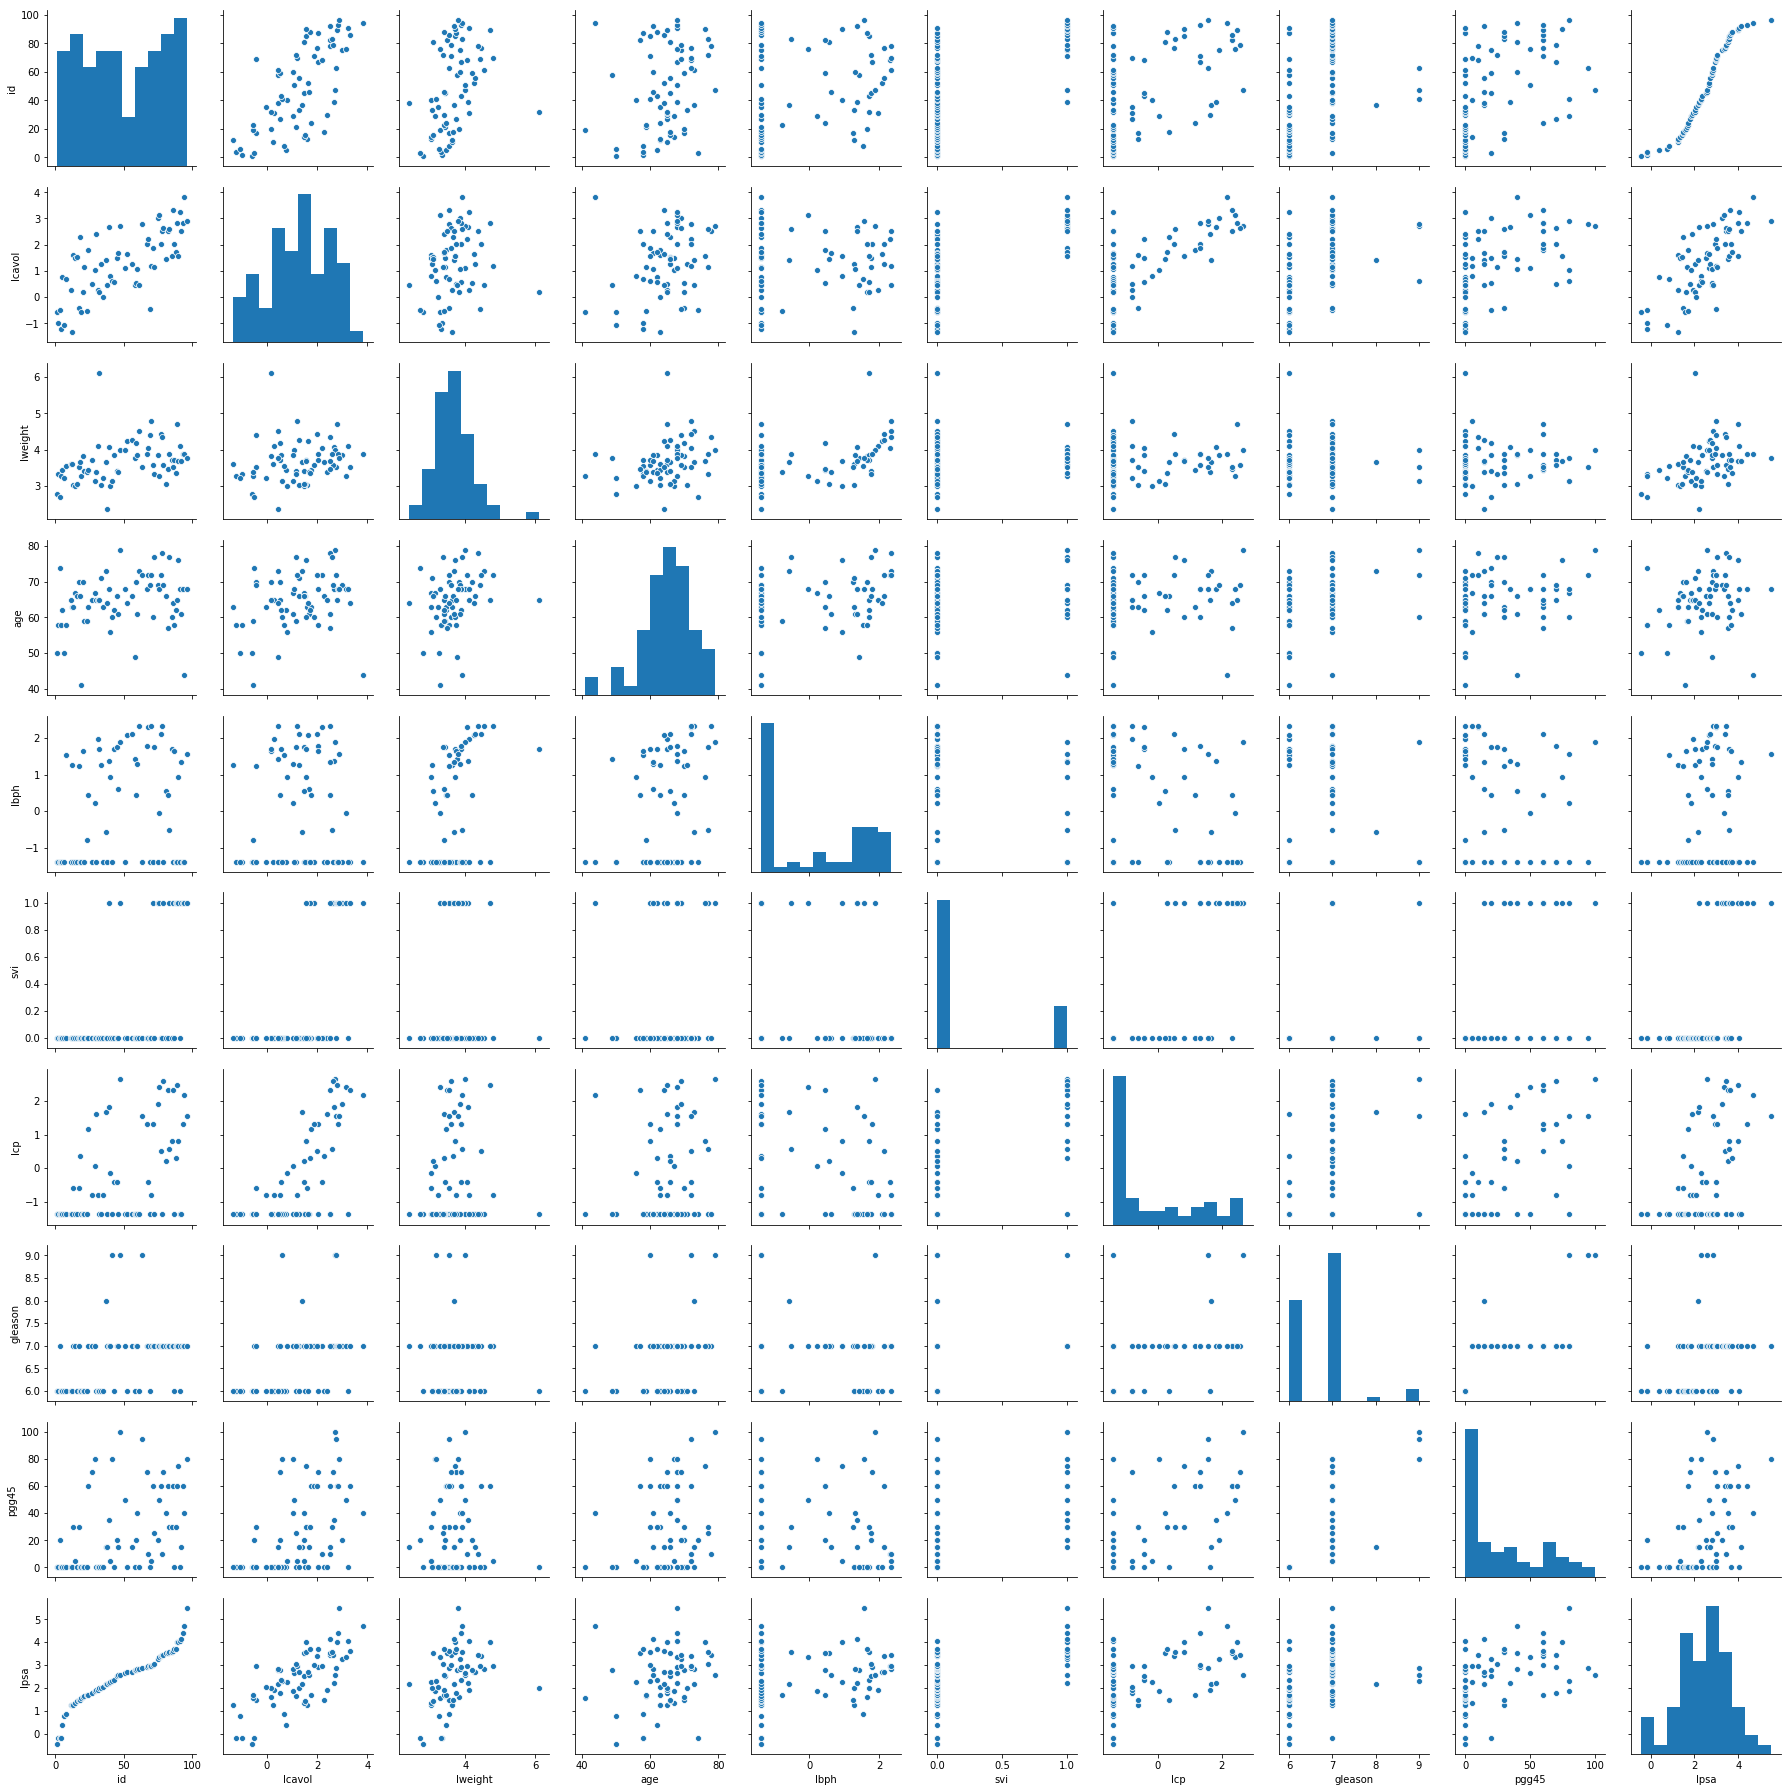

In [7]:
sns.pairplot(train_df)

Есть несколько категориальных признаков, кроме того, заметна явная зависимость целевой переменной от id.

Получим baseline - просто линейную модель без настроек и регуляризации. Будем оценивать качество по LeaveOneOut (эквивалентно кросс-валидации по n фолдам).

In [8]:
X_train, y_train = train_df.drop('lpsa', 1), train_df['lpsa']
X_test = test_df.drop('lpsa', 1)

In [9]:
base = LinearRegression()
base.fit(X_train, y_train)
base_pred = base.predict(X_train)

In [10]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [11]:
scores = -cross_val_score(base, X_train, y_train, scoring=rmse_scorer, cv=len(X_train))
np.mean(scores)

0.26612330069485535

Проведем анализ остатков.

In [12]:
rss = np.sum((base_pred - y_train) ** 2)
eps = (base_pred - y_train) / np.sqrt(rss / (len(train_df) - len(X_train.columns)))


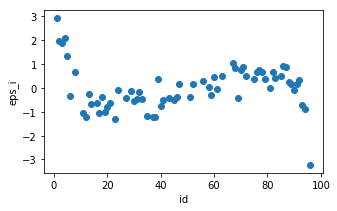

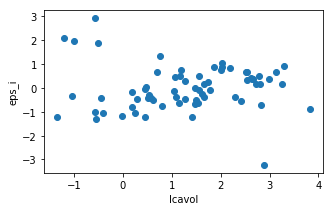

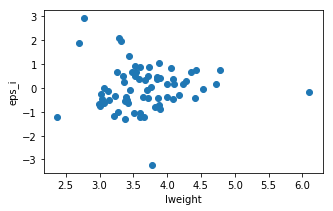

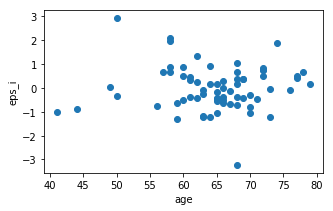

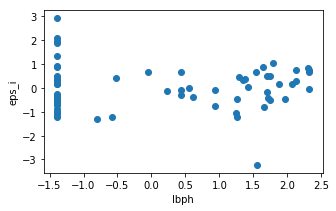

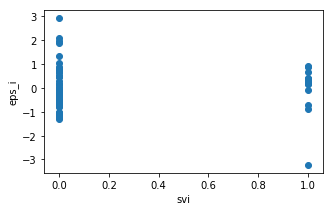

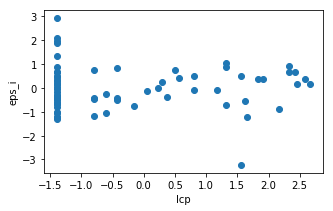

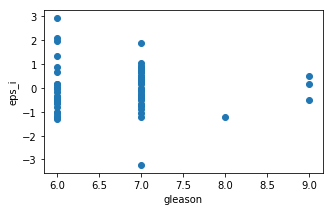

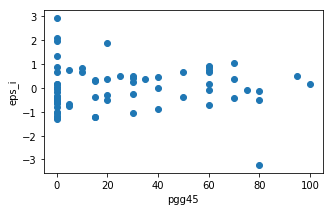

In [13]:
for col in X_train.columns:
    plt.figure(figsize=(5,3))
    plt.scatter(X_train[col], eps)
    plt.xlabel(col)
    plt.ylabel('eps_i')

Анализ остатков убеждает нас в наличии зависимости целевой переменной от id. Кроме того, в признаке lweight есть выброс, от которого неплохо было бы избавиться.

In [14]:
train_df_mod = train_df.drop(train_df['lweight'].idxmax(), 0)
X_train, y_train = train_df_mod.drop('lpsa', 1), train_df_mod['lpsa']
no_out = LinearRegression()
no_out.fit(X_train, y_train)
base_pred = no_out.predict(X_train)
scores = -cross_val_score(no_out, X_train, y_train, scoring=rmse_scorer, cv=len(X_train))
np.mean(scores)

0.27026393608587

Хотя лосс по кросс-валидации и стал больше, обобщающая способность модели должна была вырасти, так как в тестовой выборке нет выбросов по этому признаку.

У нас есть категориальный признак svi, который принимает всего два значения, поэтому с ним ничего не надо делать, и категориальный признак gleason, к которому мы применим one-hot encoding. Кроме того, зависимость между id и lpsa похожа на полиномиальную, поэтому добавим куб и квадрат этого признака, чтобы линейная модель смогла восстановить полиномиальную зависимость.

In [15]:
gl_unique = train_df_mod['gleason'].unique()
gl_cols = []
for i in range(len(gl_unique)):
    gl_cols.append('gleason_' + str(int(gl_unique[i])))
gl_cols

['gleason_6', 'gleason_7', 'gleason_8', 'gleason_9']

In [16]:
oenc = OneHotEncoder(categories='auto', sparse=False)
encoded_train = oenc.fit_transform(train_df_mod[['gleason']])
encoded_test = oenc.transform(test_df[['gleason']])
train_df_enc = train_df_mod.copy()
test_df_enc = test_df.copy()

for i, col in enumerate(gl_cols):
    test_df_enc[col] = encoded_test[:, i]
    train_df_enc[col] = encoded_train[:, i]

In [17]:
train_df_enc['id2'] = train_df_enc['id'] ** 2
train_df_enc['id3'] = train_df_enc['id'] ** 3
test_df_enc['id2'] = test_df_enc['id'] ** 2
test_df_enc['id3'] = test_df_enc['id'] ** 3

In [18]:
test_df_enc.drop('gleason', 1, inplace=True)
train_df_enc.drop('gleason', 1, inplace=True)

In [19]:
model_enc = LinearRegression()

In [21]:
X_train, y_train = train_df_enc.drop('lpsa', 1), train_df_enc['lpsa']
scores = -cross_val_score(model_enc, X_train, y_train, scoring=rmse_scorer, cv=len(X_train))
np.mean(scores)

0.1499780875592464

Подготовим итоговый файл.

In [25]:
model_enc.fit(X_train, y_train)
test_df_enc['lpsa'] = model_enc.predict(test_df_enc.drop('lpsa', 1))

In [26]:
submission = pd.read_csv('Prostate_sample.csv')
submission.head()

,id,lpsa
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [27]:
submission['lpsa'] = pd.concat((train_df, test_df_enc), axis=0, sort=False).sort_values(by=['id'])['lpsa']
submission.head()

,id,lpsa
0,1,-0.430783
1,2,-0.162519
2,3,-0.162519
3,4,-0.162519
4,5,0.371564


In [32]:
submission.to_csv('sub9-2.csv', index=False)

## Задача 2.

In [251]:
df = pd.read_csv('hw9t3_train_2019.csv')
df.head()

,id,Fadeev,Khaldeev,Pepermaldeev,kees,top hat,turtle,gloves,small cart,cardboard,...,elefant,zeta function,Alla Pugachyova,soldering iron,frypan,drums,yellow submarine,sleep,mood,duration
0,1,1,1,1,0,0,0,1,1,1,...,0,1,1,0,0,0,1,3.418333,frivolous,11.851099
1,2,0,1,1,1,1,0,1,0,0,...,0,0,0,0,0,1,1,3.082370,so-so,NaN
2,3,0,0,1,1,1,1,1,1,0,...,0,0,0,0,0,1,1,3.229007,so-so,3.751619
3,4,1,1,1,1,1,1,1,1,1,...,1,0,0,1,1,1,0,2.513620,emotional,9.366979
4,5,1,1,1,0,0,1,1,1,1,...,0,0,0,1,1,0,0,3.045402,frivolous,NaN


In [252]:
train_df = df[df['duration'].notnull()]
len(train_df)

378

In [253]:
test_df = df[~df['duration'].notnull()]
len(test_df)

122

In [254]:
df['mood'].unique()

array(['frivolous', 'so-so', 'emotional', 'good', 'excellent', 'apathic',
       'bad', 'moody'], dtype=object)

Сразу проведем encoding категориальных признаков.

In [255]:
mood_unique = df['mood'].unique()
mood_cols = []
for i in range(len(mood_unique)):
    mood_cols.append('mood_' + str(mood_unique[i]))
mood_cols

['mood_frivolous',
 'mood_so-so',
 'mood_emotional',
 'mood_good',
 'mood_excellent',
 'mood_apathic',
 'mood_bad',
 'mood_moody']

In [256]:
oenc = OneHotEncoder(categories='auto', sparse=False)
encoded_train = oenc.fit_transform(train_df[['mood']])
encoded_test = oenc.transform(test_df[['mood']])
train_df_enc = train_df.copy()
test_df_enc = test_df.copy()

for i, col in enumerate(mood_cols):
    test_df_enc[col] = encoded_test[:, i]
    train_df_enc[col] = encoded_train[:, i]

In [257]:
train_df_enc.drop('mood', 1, inplace=True)
test_df_enc.drop('mood', 1, inplace=True)

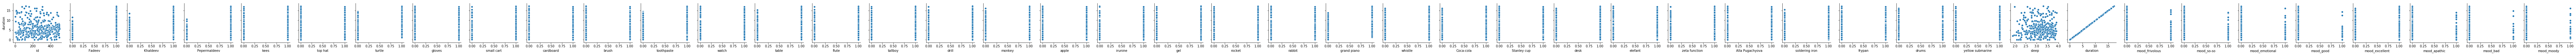

In [258]:
sns.pairplot(train_df_enc, x_vars=train_df_enc.columns, y_vars=['duration'])

(картинка кликабельна)

In [259]:
X_train, y_train = train_df_enc.drop(['id', 'duration'], 1), train_df_enc['duration']
X_test = test_df_enc.drop(['id', 'duration'], 1)

In [260]:
base = LinearRegression()
base.fit(X_train, y_train)
base_pred = base.predict(X_train)

Тут датасет побольше, поэтому будем использовать кросс-валидацию на 10 фолдов.

In [261]:
scores = -cross_val_score(base, X_train, y_train, scoring=rmse_scorer, cv=10)
np.mean(scores)

1.3531079637375452

In [262]:
rmse(base_pred, train_df_enc['duration'])

1.1855907692361978

Анализ остатков (для некоторых признаков)

In [263]:
train_df.columns

Index(['id', 'Fadeev', 'Khaldeev', 'Pepermaldeev', 'kees', 'top hat', 'turtle',
       'gloves', 'small cart', 'cardboard', 'brush', 'toothpaste', 'watch',
       'table', 'flute', 'tallboy', 'drill', 'monkey', 'apple', 'irunine',
       'gel', 'rocket', 'rabbit', 'grand piano', 'whistle', 'Coca-cola',
       'Stanley cup', 'desk', 'elefant', 'zeta function', 'Alla Pugachyova',
       'soldering iron', 'frypan', 'drums', 'yellow submarine', 'sleep',
       'mood', 'duration'],
      dtype='object')

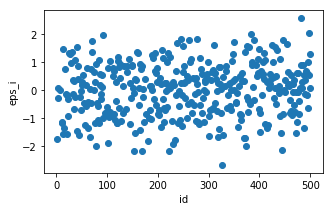

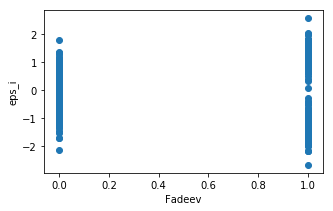

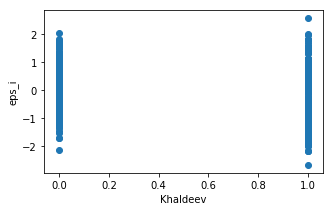

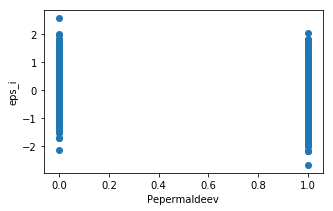

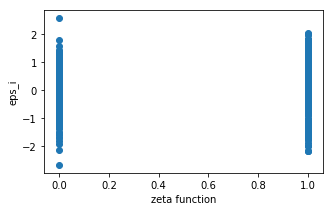

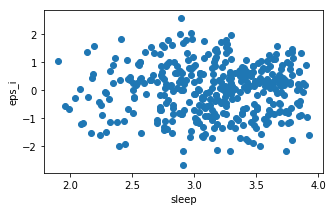

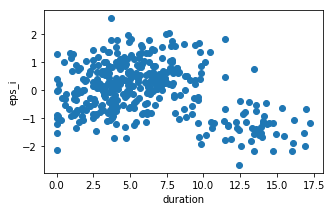

In [264]:
rss = np.sum((base_pred - y_train) ** 2)
eps = (base_pred - y_train) / np.sqrt(rss / (len(train_df_enc) - len(X_train.columns)))
cols = ['id', 'Fadeev', 'Khaldeev', 'Pepermaldeev', 'zeta function', 'sleep', 'duration']
for col in cols:
    plt.figure(figsize=(5,3))
    plt.scatter(train_df_enc[col], eps)
    plt.xlabel(col)
    plt.ylabel('eps_i')

От id, кажется, ничего не зависит, выбросов тоже не наблюдается. Попробуем произвести отбор признаков с помощью ExtraTrees (об этом было рассказано на лекции).

In [265]:
trees = RandomForestRegressor(n_estimators=20)
trees.fit(X_train, y_train)
trees.feature_importances_  

array([3.93280231e-01, 1.07063395e-01, 1.72643360e-01, 3.51509385e-03,
       2.74163558e-03, 6.74347632e-02, 4.10297836e-03, 3.25507314e-03,
       2.98534297e-03, 1.56823015e-03, 4.07777382e-03, 1.20006860e-02,
       1.78269859e-02, 2.39175052e-03, 1.79740911e-03, 2.38833622e-03,
       4.59850459e-03, 3.95022567e-03, 4.59989394e-02, 1.90452973e-03,
       2.57013447e-03, 2.29373154e-03, 2.82508229e-02, 2.66994070e-03,
       2.10037753e-03, 2.47335127e-03, 5.33559824e-03, 2.61596474e-03,
       1.05524910e-02, 6.88276822e-03, 3.96974210e-03, 1.35690702e-03,
       2.84359446e-03, 3.21435926e-03, 2.84079094e-02, 1.51164536e-03,
       9.36798910e-04, 1.60734446e-03, 4.97043551e-04, 3.10086780e-02,
       1.89993578e-03, 1.24422226e-04, 1.35119392e-03])

Возьмем 25 самых важных признаков.

In [266]:
pairs = list(enumerate(trees.feature_importances_))
pairs.sort(key = lambda a : a[1], reverse=True)

In [267]:
nums = [num for (num, imp) in pairs[:25]]
imp_cols = list(X_train.columns[nums])
imp_cols

['Fadeev',
 'Pepermaldeev',
 'Khaldeev',
 'turtle',
 'irunine',
 'mood_excellent',
 'sleep',
 'grand piano',
 'table',
 'watch',
 'zeta function',
 'Alla Pugachyova',
 'desk',
 'monkey',
 'gloves',
 'toothpaste',
 'soldering iron',
 'apple',
 'kees',
 'small cart',
 'yellow submarine',
 'cardboard',
 'drums',
 'top hat',
 'whistle']

In [268]:
X_train_cut, y_train_cut = train_df_enc[imp_cols], train_df_enc['duration']
X_test = test_df_enc.drop(['id', 'duration'], 1)

In [269]:
scores = -cross_val_score(base, X_train_cut, y_train_cut, scoring=rmse_scorer, cv=10)
np.mean(scores)

1.3520945124793522

Стало чуть лучше. Возможно, длительность прогулки нелинейно зависит от количества человек в компании. Проверим это.

In [270]:
num_company = train_df_enc['Fadeev'] + train_df_enc['Pepermaldeev'] + train_df_enc['Khaldeev']

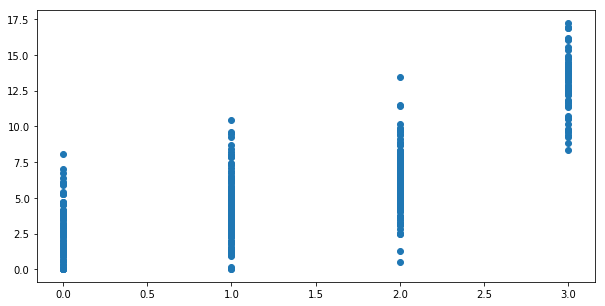

In [271]:
plt.scatter(num_company, train_df_enc['duration'])

Действительно, зависимость есть. Добавим отдельно три бинарных признака с этим количеством (т.к. оно дискретное, и так модель сможет сама имитировать полиномиальную зависимость)

In [272]:
train_df_num = train_df_enc.copy()
test_df_num = test_df_enc.copy()
train_df_num['1friend'] = np.where(num_company == 1, 1, 0)
train_df_num['2friends'] = np.where(num_company == 2, 1, 0)
train_df_num['3friends'] = np.where(num_company == 3, 1, 0)
num_company_test = test_df_enc['Fadeev'] + test_df_enc['Pepermaldeev'] + test_df_enc['Khaldeev']
test_df_num['1friend'] = np.where(num_company_test == 1, 1, 0)
test_df_num['2friends'] = np.where(num_company_test == 2, 1, 0)
test_df_num['3friends'] = np.where(num_company_test == 3, 1, 0)

In [273]:
ridge = Ridge()
X_train_num, y_train_num = train_df_num.drop(['id', 'duration'], 1), train_df_num['duration']
scores = -cross_val_score(ridge, X_train_num, y_train_num, scoring=rmse_scorer, cv=10)
np.mean(scores)

0.5503401446301815

In [274]:
ridge.fit(X_train_num, y_train_num)
ridge.coef_

array([ 1.67846752e+00,  1.72204968e+00,  1.76517952e+00, -1.24224018e-02,
        6.20289662e-03,  2.10731524e+00, -3.35799615e-01, -6.46794485e-02,
        1.27946246e-01, -6.04011614e-02,  4.39636338e-03, -1.49071662e+00,
        1.36213337e+00, -9.58128806e-03,  1.39241683e-01, -1.61168531e-01,
        1.13860457e-01, -2.02391064e-03,  1.54937393e+00,  2.23630843e-01,
       -1.32608282e-02,  2.31599122e-01,  1.53121489e+00,  1.93600784e-02,
       -2.59942690e-02, -1.37330597e-01,  5.93778823e-02, -5.48932616e-01,
        1.19249603e+00, -9.01837110e-01,  1.48421204e-01, -7.48756876e-02,
        2.23660370e-01,  1.15104355e-01,  1.11281891e-01, -1.58341220e-01,
       -1.19782244e-01, -2.78362147e-01, -3.51465416e-01,  1.33769717e+00,
        5.51562454e-02, -4.47586426e-01, -3.73159592e-02, -1.12493682e+00,
       -1.04031205e+00,  2.79041921e+00])

Попробуем совместить два способа.

In [275]:
imp_cols2 = imp_cols + ['1friend', '2friends', '3friends']

In [276]:
ridge = Ridge()
X_train_num_cut, y_train_num_cut = train_df_num[imp_cols2], train_df_num['duration']
scores = -cross_val_score(ridge, X_train_num_cut, y_train_num_cut, scoring=rmse_scorer, cv=10)
np.mean(scores)

0.6369802397174601

Стало хуже. Не будем ограничивать модель в выборе признаков и подберем параметр регуляризации.

In [277]:
parameters = {
    'alpha': np.logspace(-4, 2, 50),
}
gsearch = GridSearchCV(ridge, parameters, cv=10, scoring=rmse_scorer, iid=False)
gsearch.fit(X_train_num, y_train_num)
-gsearch.best_score_, gsearch.best_params_

(0.5501742786489416, {'alpha': 0.6250551925273969})

In [278]:
gsearch.best_estimator_.fit(X_train_num, y_train_num)

Ridge(alpha=0.6250551925273969, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

На всякий случай посчитаем метрику на train.

In [279]:
rmse(gsearch.best_estimator_.predict(X_train_num), y_train_num)

0.4694486872757816

Получим предсказания на тесте.

In [220]:
test_df_num['duration'] = gsearch.best_estimator_.predict(test_df_num.drop(['id','duration'], 1))

In [242]:
submission = pd.read_csv('hw9t3_sample.csv')
submission.head()

,id,duration
0,0,6.2
1,1,6.2
2,2,6.2
3,3,6.2
4,4,6.2


In [243]:
submission['duration'] = pd.concat((train_df_num, test_df_num), axis=0, sort=False).sort_values(by=['id'])['duration']
submission.head()

,id,duration
0,0,11.851099
1,1,6.670500
2,2,3.751619
3,3,9.366979
4,4,12.459993


In [244]:
submission['id'] = submission['id'] + 1

In [245]:
submission.head()

,id,duration
0,1,11.851099
1,2,6.670500
2,3,3.751619
3,4,9.366979
4,5,12.459993


In [246]:
submission.to_csv('sub9-3.csv', index=False)